<img src="assets/title.png" width="800px"/>

<br><br>

# Experiments

In this notebook, we explore data and experiment iteratively.

## Part 1 - Data Exploration

2 datasets are used:
- TLC NYC Taxi trips (2015) - [link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- NOAA Climate data of JFK airport, NYC (2015) - [link](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail)

### TLC NYC Taxi trips
Contains taxi trips, whose duration we seek to predict.
<br><br>

| Column name | Description |
| :- | :- |
| vendor_id | TPEP provider that provided the record |
| pickup_datetime | The start date of the ride |
| dropoff_datetime | The end date of the ride |
| passenger_count | Number of passenger |
| trip_distance | The distance in Mile of the ride |
| pickup_longitude | The longitude of starting point of the ride |
| pickup_latitude | The latitude of starting point of the ride |
| rate_code | The rate code |
| store_and_fwd_flag | Trip record held in vehicle memory before sending to the vendor |
| dropoff_longitude | The longitude of end point of the ride |
| dropoff_latitude | The longitude of end point of the ride |
| payment_type | Type of payment |
| fare_amount | Amount of the ride in dollars |

More details on data schema on the [NYC TLC website](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)


### NOAA Climate data of JFK airport, NYC
Contains weather information.
Most 'important' columns are:
<br><br>

| Column name | Description |
| :- | :- |
| TMAX | Maximum temperature |
| TMIN | Minimum temperature |
| PRCP | Precipitation |
| SNOW | Snowfall |
| SNWD | Snow depth |
| ACMH | Average cloudiness midnight to midnight |
| TSUN | Total sunshine for the period |
| AWND | Average wind speed |

Full data schema is available on the [NOAA website](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail)


In [1]:
# Logging is disabled to avoid uncomfortable logs from third party libraries
import logging

logging.disable()


In [2]:
from src.data import get_train_dataset

data = get_train_dataset()


In [3]:
import ydata_profiling as pandas_profiling

pandas_profiling.ProfileReport(data).to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from src.data import get_target

target = get_target(data)
target.head()


0    2104
1    1671
2    2603
3    1797
4    1782
Name: trip_duration, dtype: int32

## Part 2 : Base features importance

In [20]:
from sklearn.model_selection import train_test_split

from src.schemas import TaxiColumn
from src.config import config

train_idx, test_idx = train_test_split(
    data.sort_values(TaxiColumn.PICKUP_TIME).index,
    test_size=config.test_size,
    shuffle=False,
)

print(f"Train size: {len(train_idx)} trips")
print(f"Test size: {len(test_idx)} trips")


Train size: 16928 trips
Test size: 8338 trips


In [6]:
COLS_TO_EXTRACT = [
    TaxiColumn.VENDOR_ID,
    TaxiColumn.PASSENGER_COUNT,
    TaxiColumn.PICKUP_LON,
    TaxiColumn.PICKUP_LAT,
    TaxiColumn.DROPOFF_LON,
    TaxiColumn.DROPOFF_LAT,
]

features = data.loc[:, COLS_TO_EXTRACT]
features.head()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1,1,-73.974998,40.756504,-73.872536,40.774345
1,2,5,-74.001587,40.741020,-73.955109,40.685692
2,2,6,-73.975739,40.762390,-73.861626,40.768303
3,1,1,-73.954071,40.766953,-74.009018,40.731213
4,2,1,-73.863098,40.769184,-73.964119,40.679508


In [7]:
train_features, train_target = features.iloc[train_idx], target.iloc[train_idx]
test_features, test_target = features.iloc[test_idx], target.iloc[test_idx]


In [8]:
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

model = RandomForestRegressor(random_state=RANDOM_STATE).fit(train_features, train_target)


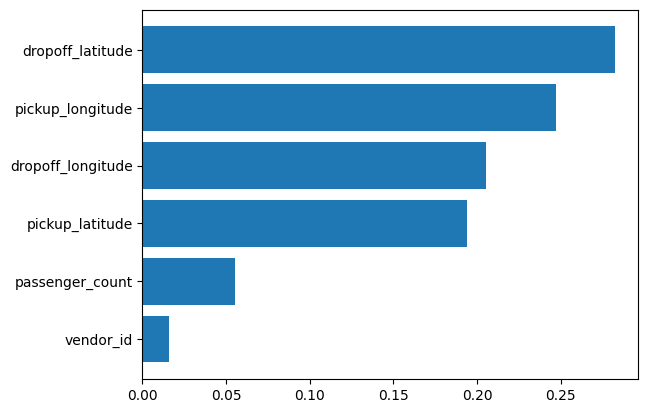

In [9]:
%matplotlib inline

from matplotlib import pyplot as plt

sorted_idx = model.feature_importances_.argsort()

plt.barh(model.feature_names_in_[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()


## Part 3 : Evaluation

In [10]:
import pandas as pd
from sklearn.model_selection import cross_validate, TimeSeriesSplit

N_SPLITS = 5

model = RandomForestRegressor(random_state=RANDOM_STATE)
splitter = TimeSeriesSplit(n_splits=N_SPLITS)

cv_scores = cross_validate(
    model,
    features,
    target,
    scoring='neg_mean_squared_log_error',
    cv=splitter,
)


In [11]:
pd.DataFrame(cv_scores).agg(['mean', 'std'])


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error
mean,3.926140,0.073070,-653.653690,-8.372126e+06
std,2.299511,0.012175,28.901709,1.704697e+06


<img src="assets/nibble.png" width="300px"/>
